In [1]:
import pandas as pd
import os
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.nn import TransformerEncoder
import ffn
import numpy as np
from binned_data_loading import *

In [2]:
"""Training params"""
context_length = 7
predict_length = 1
batch_size=512
epochs=50

"""Quantization params"""
lower_bin = -5
upper_bin = 5
num_bins = 20

In [3]:
"""Get closings and log returns"""
tick='aapl'
returns_train = get_log_returns(tick=tick, start='2020-01-01', end='2022-01-01')
returns_test = get_log_returns(tick=tick, start='2022-01-01', end='2024-01-01')
returns_train

[*********************100%%**********************]  1 of 1 completed

yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.



[*********************100%%**********************]  1 of 1 completed


,aapl
Date,
2020-01-03,-0.009770
2020-01-06,0.007936
2020-01-07,-0.004714
2020-01-08,0.015958
2020-01-09,0.021018
...,...
2021-12-27,0.022715
2021-12-28,-0.005784
2021-12-29,0.000502


In [4]:
"""Bin the returns"""
returns_train['binned_returns'] = bin_returns(returns_train[tick], lower_bin=lower_bin, upper_bin=upper_bin, num_bins=num_bins)
returns_test['binned_returns'] = bin_returns(returns_test[tick], lower_bin=lower_bin, upper_bin=upper_bin, num_bins=num_bins)
returns_train, returns_test

(                aapl binned_returns
 Date                               
 2020-01-03 -0.009770              8
 2020-01-06  0.007936             11
 2020-01-07 -0.004714              9
 2020-01-08  0.015958             12
 2020-01-09  0.021018             13
 ...              ...            ...
 2021-12-27  0.022715             14
 2021-12-28 -0.005784              8
 2021-12-29  0.000502             10
 2021-12-30 -0.006600              8
 2021-12-31 -0.003542              9
 
 [504 rows x 2 columns],
                 aapl binned_returns
 Date                               
 2022-01-04 -0.012773              7
 2022-01-05 -0.026960              5
 2022-01-06 -0.016834              6
 2022-01-07  0.000988             10
 2022-01-10  0.000116             10
 ...              ...            ...
 2023-12-22 -0.005563              8
 2023-12-26 -0.002845              9
 2023-12-27  0.000518             10
 2023-12-28  0.002224             10
 2023-12-29 -0.005439              9
 
 [500 row

<Axes: >

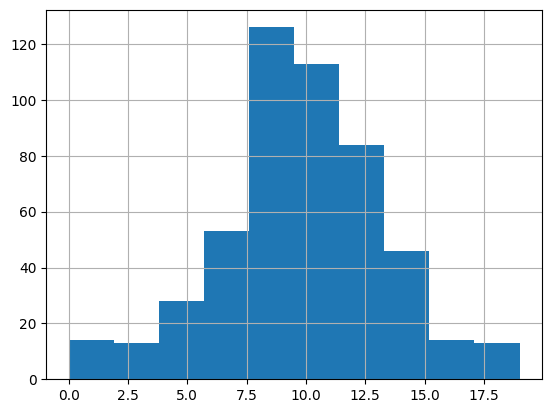

In [5]:
returns_train['binned_returns'].hist()


<Axes: >

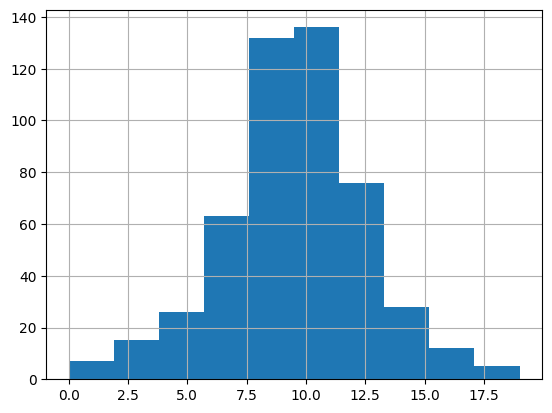

In [6]:
returns_test['binned_returns'].hist()

In [7]:
"""
proportions: A vector representing the frequency of each bin (captures the above histogram)--
This can be used while training to prevent the model from just predicting the most 
common values (eg. by weighting less frequent bins more)
"""
proportions = torch.tensor(returns_train['binned_returns'].value_counts(sort=False))
proportions = 2-proportions/torch.max(proportions)
proportions, returns_train['binned_returns'].value_counts(sort=False)

(tensor([1.8714, 1.9286, 1.9429, 1.8714, 1.8000, 1.8000, 1.7714, 1.4714, 1.2000,
         1.0000, 1.0286, 1.3571, 1.2571, 1.5429, 1.6429, 1.7000, 1.8714, 1.9286,
         1.9571, 1.8571]),
 binned_returns
 0      9
 1      5
 2      4
 3      9
 4     14
 5     14
 6     16
 7     37
 8     56
 9     70
 10    68
 11    45
 12    52
 13    32
 14    25
 15    21
 16     9
 17     5
 18     3
 19    10
 Name: count, dtype: int64)

In [27]:
import plotly.graph_objs as go
import pandas as pd

fig = go.Figure()
df = returns_train.copy()
fig.add_trace(go.Scatter(x=df.index, y=df['binned_returns'].cat.codes/100-0.1, name='Returns Binned'))
fig.add_trace(go.Scatter(x=df.index, y=df['aapl'], name='Returns Raw'))

fig.update_layout(title='Returns over Time',
                  xaxis_title='Time',
                  yaxis_title='Returns',
                  width=800,
                  height=600)

fig

In [28]:
"""Dataloader"""
class BucketDataSet(Dataset):
    def __init__(self, df:pd.DataFrame):
        self.len = len(df.index)
        self.src = df.to_dict(orient='list')#.values.reshape(-1, 1)

    def __getitem__(self, idx) -> torch.Tensor:
        return {
            k : torch.tensor(v[idx]).float().to('cpu') for k, v in self.src.items() #k:torch.tensor(self.src[k]) for k in self.src[idx]
        }

    def __len__(self):
        return self.len#(self.src)

In [29]:
"""Window Splitting"""
rolling_bins = get_rolling_window(df=returns_train['binned_returns'], context_length=context_length, predict_length=predict_length)
rolling_bins_test = get_rolling_window(df=returns_test['binned_returns'], context_length=context_length, predict_length=predict_length)
data_df = pd.DataFrame({'x':rolling_bins})
data_df_test = pd.DataFrame({'x':rolling_bins_test})

data_df, data_df_test

(                                  x
 0     [8, 11, 9, 12, 13, 10, 13, 7]
 1     [11, 9, 12, 13, 10, 13, 7, 9]
 2     [9, 12, 13, 10, 13, 7, 9, 12]
 3    [12, 13, 10, 13, 7, 9, 12, 11]
 4     [13, 10, 13, 7, 9, 12, 11, 8]
 ..                              ...
 491    [8, 15, 2, 8, 8, 13, 12, 10]
 492   [15, 2, 8, 8, 13, 12, 10, 14]
 493    [2, 8, 8, 13, 12, 10, 14, 8]
 494   [8, 8, 13, 12, 10, 14, 8, 10]
 495   [8, 13, 12, 10, 14, 8, 10, 8]
 
 [496 rows x 1 columns],
                                  x
 0     [7, 5, 6, 10, 10, 12, 10, 6]
 1    [5, 6, 10, 10, 12, 10, 6, 10]
 2    [6, 10, 10, 12, 10, 6, 10, 6]
 3    [10, 10, 12, 10, 6, 10, 6, 6]
 4     [10, 12, 10, 6, 10, 6, 6, 8]
 ..                             ...
 487   [11, 12, 10, 9, 8, 10, 8, 9]
 488    [12, 10, 9, 8, 10, 8, 9, 8]
 489     [10, 9, 8, 10, 8, 9, 8, 9]
 490     [9, 8, 10, 8, 9, 8, 9, 10]
 491    [8, 10, 8, 9, 8, 9, 10, 10]
 
 [492 rows x 1 columns])

In [30]:
list(data_df.iloc[0]['x'])

[8, 11, 9, 12, 13, 10, 13, 7]

In [31]:
"""Forward: similar setup to seq2seq, where src is text context and tgt's 'begin' token is embedded past prices/rets and tgt is the future rets"""
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer, TransformerEncoder, TransformerEncoderLayer
import math
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module): # Check this out: https://arxiv.org/pdf/1907.05321 
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        
        print("position embedding shape: ", pos_embedding.shape)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding) # Not a model param; position embeddings aren't learnt

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(1),:])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size
    

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

class BucketTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(BucketTransformer, self).__init__()
        self.encoder_layer = TransformerEncoderLayer(d_model=emb_size,
                                       nhead=nhead,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout,
                                       batch_first=True)
        self.encoder = TransformerEncoder(encoder_layer=self.encoder_layer, num_layers=num_encoder_layers)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)
        self.src_tok_emb = TokenEmbedding(vocab_size, emb_size)
        self.generator = nn.Linear(emb_size, vocab_size)

    def forward(self, word, reduce_mean=False):
        embedded = self.src_tok_emb(word)
        emb_1 = self.positional_encoding(embedded)
        encoded = self.encoder(src=emb_1, is_causal=True, mask=Transformer.generate_square_subsequent_mask(sz=len(emb_1)))#[:, 0]#[0]

        if reduce_mean:
            encoded = encoded.mean(1)   
            return self.generator(encoded)
        
        return self.generator(encoded[:,0]) # BERT Strategy (start token's embedding used for downstream task)



In [32]:
"""Initialize dataloader"""
data_set_train = BucketDataSet(data_df)#returns['binned_returns'])
data_loader_train = DataLoader(dataset=data_set_train, batch_size=batch_size)

data_set_test = BucketDataSet(data_df_test)
data_loader_test = DataLoader(dataset=data_set_test)#, batch_size=batch_size)
data_loader_eval = DataLoader(dataset=data_set_test, batch_size=batch_size) # Same as prev but batched

In [33]:
"""Check data"""
data_set_train[6]
x=data_set_train[7]['x']
src = x[:context_length]#
tgt = x[-predict_length].long()
x, src, tgt

(tensor([ 7.,  9., 12., 11.,  8., 10., 10.,  9.]),
 tensor([ 7.,  9., 12., 11.,  8., 10., 10.]),
 tensor(9))

In [34]:
data_set_train[0]

{'x': tensor([ 8., 11.,  9., 12., 13., 10., 13.,  7.])}

In [36]:

SRC_VOCAB_SIZE = num_bins#12
EMB_SIZE = 256
NHEAD = 8
FFN_HID_DIM = 384
NUM_ENCODER_LAYERS = 5
DROPOUT = 0.02675807756164278

# Learning params
LR = 0.0001#0.00029186200149147875
BETAS = (0.9, 0.98)
EPS = 1e-9
# optimizer = torch.optim.AdamW(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
transformer = BucketTransformer(
    num_encoder_layers=NUM_ENCODER_LAYERS,
    emb_size=EMB_SIZE,
    nhead=NHEAD,
    vocab_size=SRC_VOCAB_SIZE,
    dim_feedforward=FFN_HID_DIM,
    dropout = DROPOUT
)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(weight=proportions**2) # To weigh less common 
optimizer = torch.optim.AdamW(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

position embedding shape:  torch.Size([5000, 256])


In [37]:
len(list(transformer.parameters()))

75

In [38]:
"""Train loop"""
def train_epoch(model:nn.Module, data_loader:DataLoader):
    model.train()
    losses=0
    for pt in data_loader:
        # print("data_pt: ", pt)
        x = pt['x']

        src = x[:,:context_length]#pt[:-1]
        tgt = x[:,context_length].long()#.unsqueeze(dim=1)#context_length+predict_length]#pt[-1]

        # print('x: ', x, context_length)
        # print("src: ", src.shape)
        # print("tgt: ", tgt.shape)

        logits = model(src)
        # print("logits: ", logits.shape)
        logits_softmax = torch.softmax(logits, dim=1)
        
        # print("logits softmax: ", logits_softmax)

        optimizer.zero_grad(set_to_none=True)

        loss = loss_fn(logits_softmax.float(), torch.nn.functional.one_hot(tgt, num_classes=SRC_VOCAB_SIZE).float()).float()
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(list(data_loader))

def eval(model:nn.Module, data_loader:DataLoader, get_acc=False):
    model.eval()
    losses=0
    for pt in data_loader:
        x = pt['x']

        src = x[:,:context_length]#pt[:-1]
        tgt = x[:,context_length].long()#.unsqueeze(dim=1)#context_length+predict_length]#pt[-1]

        logits = model(src)
        logits_softmax = torch.softmax(logits, dim=1)
        
        loss = loss_fn(logits_softmax.float(), torch.nn.functional.one_hot(tgt, num_classes=SRC_VOCAB_SIZE).float()).float()
        losses += loss.item()

    return losses / len(list(data_loader))

In [39]:
"""train loop"""
train_losses = []
val_losses = []
for epoch in range(epochs):
    train_loss = train_epoch(transformer, data_loader=data_loader_train)
    val_loss= eval(transformer, data_loader=data_loader_eval)#stub
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}"))#f"Epoch time = {(end_time - start_time):.3f}s")) 
    train_losses.append(train_loss)   
    val_losses.append(val_loss)

Epoch: 0, Train loss: 6.007, Val loss: 5.731
Epoch: 1, Train loss: 5.967, Val loss: 5.719
Epoch: 2, Train loss: 5.952, Val loss: 5.722
Epoch: 3, Train loss: 5.920, Val loss: 5.729
Epoch: 4, Train loss: 5.921, Val loss: 5.734
Epoch: 5, Train loss: 5.910, Val loss: 5.737
Epoch: 6, Train loss: 5.912, Val loss: 5.739
Epoch: 7, Train loss: 5.901, Val loss: 5.743
Epoch: 8, Train loss: 5.890, Val loss: 5.745
Epoch: 9, Train loss: 5.890, Val loss: 5.746
Epoch: 10, Train loss: 5.892, Val loss: 5.745
Epoch: 11, Train loss: 5.889, Val loss: 5.742
Epoch: 12, Train loss: 5.885, Val loss: 5.737
Epoch: 13, Train loss: 5.876, Val loss: 5.732
Epoch: 14, Train loss: 5.878, Val loss: 5.729
Epoch: 15, Train loss: 5.888, Val loss: 5.725
Epoch: 16, Train loss: 5.880, Val loss: 5.722
Epoch: 17, Train loss: 5.883, Val loss: 5.720
Epoch: 18, Train loss: 5.871, Val loss: 5.717
Epoch: 19, Train loss: 5.874, Val loss: 5.715
Epoch: 20, Train loss: 5.870, Val loss: 5.714
Epoch: 21, Train loss: 5.876, Val loss: 5.71

In [40]:
import plotly.graph_objs as go
import pandas as pd

fig = go.Figure()
df = pd.read_csv('binned_returns.csv')#returns['binned_returns']

fig.add_trace(go.Scatter(x=list(range(len(train_losses))), y=train_losses, name='train loss'))
fig.add_trace(go.Scatter(x=list(range(len(val_losses))), y=val_losses, name='val loss'))

fig.update_layout(title='Losses',
                  xaxis_title='Epochs',
                  yaxis_title='Loss',
                  width=800,
                  height=600)

fig.show()
print("best ep: ", torch.argmin(torch.tensor(val_losses))) # 49
# torch.save(transformer, f"saved/models/mse_loss_{epochs}_{NUM_ENCODER_LAYERS}_{FFN_HID_DIM}_{EMB_SIZE}")
# num encoder, ffn hid dim, emb size

best ep:  tensor(34)


In [41]:
"""Prediction"""
predictions = []
originals = []
for pt in data_loader_test:
    x = pt['x']

    #print(src)
    src = x[:,:context_length]#pt[:-1]
    tgt = x[:,context_length].long()#.unsqueeze(dim=1)#context_length+predict_length]#pt[-1]
    
    print('x: ', x, context_length)
    print("src: ", src)
    print("tgt: ", tgt)

    logits = transformer(src).detach()
    print("logits: ", logits)
    prediction = torch.argmax(logits) # the index with largest likelihood
    print(prediction)

    predictions.append(prediction)
    originals.append(tgt)

originals = torch.tensor(originals)
predictions = torch.tensor(predictions)
predictions
    
# transformer=torch.load('/Users/ishanshastri/Desktop/nus/AML/AssetPrice/saved/models/smthg')

x:  tensor([[ 7.,  5.,  6., 10., 10., 12., 10.,  6.]]) 7
src:  tensor([[ 7.,  5.,  6., 10., 10., 12., 10.]])
tgt:  tensor([6])
logits:  tensor([[-2.5243, -2.4308, -3.0825, -0.1649, -1.4850, -1.4000, -1.0855,  5.3272,
          1.8449, -2.3314, -2.8850,  6.3437,  1.3766,  0.1793,  5.3242, -3.6840,
          0.6218,  0.9248, -4.3285, -2.5458]])
tensor(11)
x:  tensor([[ 5.,  6., 10., 10., 12., 10.,  6., 10.]]) 7
src:  tensor([[ 5.,  6., 10., 10., 12., 10.,  6.]])
tgt:  tensor([10])
logits:  tensor([[-0.2274, -2.6765, -1.1035, -0.6451, -0.6277, -1.0338, -0.9620,  2.8962,
         -1.2696, -1.3953, -1.1911,  9.4254, -0.6872,  0.2687,  0.4712, -1.5965,
          1.2614,  1.6101, -1.6467, -1.4235]])
tensor(11)
x:  tensor([[ 6., 10., 10., 12., 10.,  6., 10.,  6.]]) 7
src:  tensor([[ 6., 10., 10., 12., 10.,  6., 10.]])
tgt:  tensor([6])
logits:  tensor([[-0.6128, -1.1127,  0.1746, -1.7826, -1.8768, -0.5373, -1.6919,  4.1778,
         -0.7800, -0.8863, -2.4394,  1.2745,  1.9237,  3.7884,  8.1571

tensor([11, 11, 14, 11, 11, 13, 11, 14, 11, 14, 14, 10, 11, 10, 11, 10, 10, 17,
         8, 10, 12, 14, 10, 10,  7, 12, 11, 14, 11,  8, 10, 14, 10, 14, 11, 13,
        13, 11, 11,  7, 10, 14, 11, 11, 10, 11, 11, 11, 14, 14, 12,  7, 12,  7,
        12,  8, 11, 11,  7, 10, 14, 10,  8, 14, 14, 11, 11, 11, 13, 13, 16, 10,
        13, 10, 10, 16, 12, 10, 10,  7, 10, 11, 12,  7, 13, 11, 10, 13, 13, 11,
        14, 10,  8, 13, 11, 11,  7, 14, 11,  8,  7, 10, 10,  7,  8, 11,  7, 10,
        10,  8,  8, 12,  7,  8, 13, 14, 10,  7,  8, 10, 16, 13, 14, 13,  7, 12,
         8, 11, 11, 12, 10,  7, 13, 14,  8, 13, 13, 10, 10, 10, 10, 11, 14, 10,
        10, 10, 10, 10, 10, 11,  8, 10,  7, 12, 10, 12, 10, 11, 11, 10, 11, 13,
        10, 11, 11, 10, 11, 11, 10, 12, 10,  7, 10, 13, 12, 14, 10,  8, 13, 14,
        10, 11, 11, 12, 11, 13, 16, 14,  8, 11, 10, 10, 11, 10, 10, 14, 16, 14,
        12, 11, 10,  8, 13,  7, 14, 16, 17, 11, 14, 10,  8, 10, 11, 11, 10, 17,
         7, 10, 13, 10, 13, 11, 14, 13, 

In [42]:
def plot(originals, predictions):
    import plotly.graph_objs as go
    import pandas as pd

    fig = go.Figure()
    df = pd.read_csv('binned_returns.csv')#returns['binned_returns']

    fig.add_trace(go.Scatter(x=df['Date'], y=originals, name='OG'))
    fig.add_trace(go.Scatter(x=df['Date'], y=predictions, name='Predicted'))

    fig.update_layout(title='Returns over Time',
                    xaxis_title='Time',
                    yaxis_title='Returns',
                    width=800,
                    height=600)

    return fig

plot(originals, predictions)


In [43]:
criterion = nn.MSELoss()
criterion(predictions.float(), originals.float()), criterion(torch.tensor([1.0]), torch.tensor([1.0]))


(tensor(16.5081), tensor(0.))